In [337]:
import pandas as pd
import requests
import zipfile
import pandas as pd
import os
from io import BytesIO
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


### Extract data from url, unzip and charge to a dataframe, the data is extract from https://archive.ics.uci.edu/dataset/20/census+income

In [338]:
# URL of the ZIP file
url = 'https://archive.ics.uci.edu/static/public/20/census+income.zip'

# Download the ZIP file
response = requests.get(url)
zip_content = BytesIO(response.content)

# Extract the ZIP files
with zipfile.ZipFile(zip_content, 'r') as zip_ref:
    zip_ref.extractall("data_census")

# Path to the CSV file within the extracted directory
csv_file = 'data_census/adult.data'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file, header=None)

# Display the first 5 rows of the DataFrame
df.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
20251,52,Private,138944,11th,7,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
26407,59,Self-emp-inc,133201,5th-6th,3,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,Italy,<=50K
19748,66,Private,151793,7th-8th,4,Widowed,Other-service,Not-in-family,Black,Female,0,0,10,United-States,<=50K
3720,46,Private,56841,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
20840,39,Private,230329,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,<=50K


In [339]:
# Rename the columns to the correct name
colums_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship','race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week',
                'native-country', 'income']

df.columns = colums_names
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14903,79,Self-emp-inc,309272,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
447,51,Private,56915,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
8905,26,Private,152436,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,50,United-States,<=50K
29906,20,Private,391679,HS-grad,9,Never-married,Sales,Other-relative,White,Male,0,0,60,United-States,<=50K
27899,33,Local-gov,300681,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,<=50K


### Pre-procesing data

In [340]:
# Function to delete spaces
strip_spaces = lambda x: x.strip() if type(x) == str else x

# apply the function to the dataframe
df = df.map(strip_spaces)

In [341]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

There aren´t null data 

In [342]:
df['income'].value_counts()

income
<=50K    24720
>50K      7841
Name: count, dtype: int64

Como vemos nuestra columna objetivo tiene más datos para personas con un salario menor o igual a 50k poor año, esto puede generar que nuestro modelo este sesgado a la hora de la clasificación así que primero vamos a aplicar undersampling

In [343]:
import pandas as pd

# Supongamos que 'df' es tu DataFrame

# Separar el DataFrame en dos subconjuntos
df_50K_or_less = df[df['income'] == '<=50K']
df_more_than_50K = df[df['income'] == '>50K']

# Determinar cuál subconjunto es menor
min_size = min(len(df_50K_or_less), len(df_more_than_50K))

# Realizar undersampling en el subconjunto mayor
df_50K_or_less = df_50K_or_less.sample(n=min_size)
df_more_than_50K = df_more_than_50K.sample(n=min_size)

# Combinar los subconjuntos en un nuevo DataFrame
df  = pd.concat([df_50K_or_less, df_more_than_50K])
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
473,30,Private,303990,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,60,United-States,<=50K
19457,53,Private,217568,HS-grad,9,Widowed,Craft-repair,Unmarried,Black,Female,0,0,40,United-States,<=50K
14622,26,Private,170786,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
28051,62,Private,197918,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
141,27,Private,232782,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25803,62,Private,588484,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,20,United-States,>50K
22720,39,Private,237713,Prof-school,15,Married-civ-spouse,Sales,Husband,White,Male,0,2415,99,United-States,>50K
11192,47,?,109832,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,5178,0,30,Canada,>50K
18265,40,Private,198316,10th,6,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K


In [344]:
df['income'].value_counts()

income
<=50K    7841
>50K     7841
Name: count, dtype: int64

Now our dataframe is balanced, the next step is convert all columns to numeric information

In [345]:
import pandas as pd
import category_encoders as ce

# Find columns with string data types
# 'include=['object']' selects columns that are of the object type, typically strings in pandas
cols_to_encode = df.select_dtypes(include=['object']).columns

# Create an ordinal encoder for the found columns
# 'ce.OrdinalEncoder' is used to convert categorical text data into ordinal numerical format
encoder = ce.OrdinalEncoder(cols=cols_to_encode)

# Fit the encoder and transform the training data
# 'fit_transform' first fits the encoder to the training data, then transforms the training data
df_encoder = encoder.fit_transform(df)
df_encoder.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5970,45,1,205424,5,13,1,8,1,1,1,0,0,40,1,2
22452,51,1,355954,2,10,3,2,3,1,1,0,0,60,1,2
16753,29,1,168470,1,9,1,1,4,1,1,0,0,40,1,1
5201,76,5,33213,7,14,3,8,3,1,1,0,0,30,3,2
25673,30,4,154950,5,13,3,7,3,1,1,0,0,72,1,2
3347,36,1,252327,16,3,6,2,5,1,1,0,0,40,2,1
4338,34,6,186824,12,15,3,8,3,1,1,15024,0,40,1,2
2745,34,1,231238,1,9,3,10,3,2,1,0,0,40,1,1
30525,49,6,143482,2,10,3,8,6,1,2,0,0,65,1,2
31915,38,5,175732,1,9,1,2,1,4,1,0,0,15,1,1


### Training the model

With all data in numeric values, is time to split the data to train and to test 

In [346]:
# Split the objective data from other data

x = df_encoder.drop(['income'], axis = 1)
y = df_encoder['income']

# 30% to test y 70% to train
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.30, random_state = 42)

Now all is ready to train the model

In [347]:
from sklearn.tree import DecisionTreeClassifier

#Creacion del modelo
tree = DecisionTreeClassifier(max_depth=7, random_state = 0)

# Training the model
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=0)

## Evaluate the model

In [348]:
# Calculate predictions of the model for the data of train and test
y_train_pred_tree = tree.predict(x_train)
y_test_pred_tree = tree.predict(x_test)

#### Metrics

In [349]:
# Calculo el accuracy en Train
train_accuracy_tree = accuracy_score(y_train, y_train_pred_tree)

# Calculo el accuracy en Test
test_accuracy_tree = accuracy_score(y_test, y_test_pred_tree)

print('Accuracy in train:', train_accuracy_tree)
print('Accuracy in test:', test_accuracy_tree)

Accuracy in train: 0.8298259998178008
Accuracy in test: 0.8221041445270988


The results for train and test are really similar this is good beacuse that mean the model doesn´t have overfiting

#### Lets see what is most important features for the predict

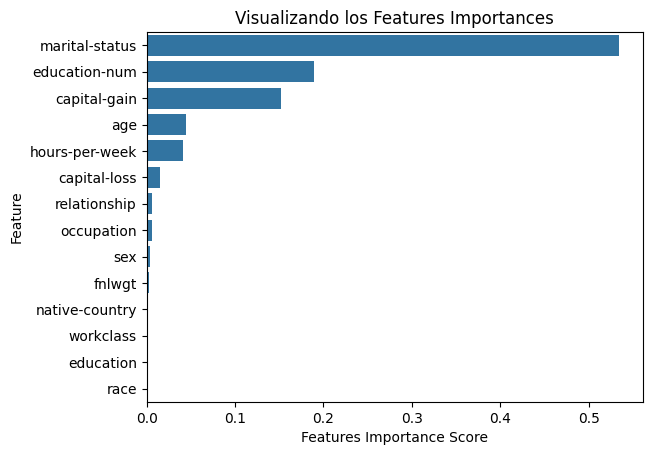

In [350]:
# Visualizacion de las feature importantes
features_scores = pd.Series(tree.feature_importances_, index = x_train.columns).sort_values(ascending=False)
features_scores

sns.barplot(x=features_scores , y = features_scores.index)
plt.xlabel('Features Importance Score')
plt.ylabel('Feature')
plt.title("Visualizando los Features Importances")
plt.show()

Is curisoity look the most importance feature is the marital status so we can do a study about what marital-status do the people have more money

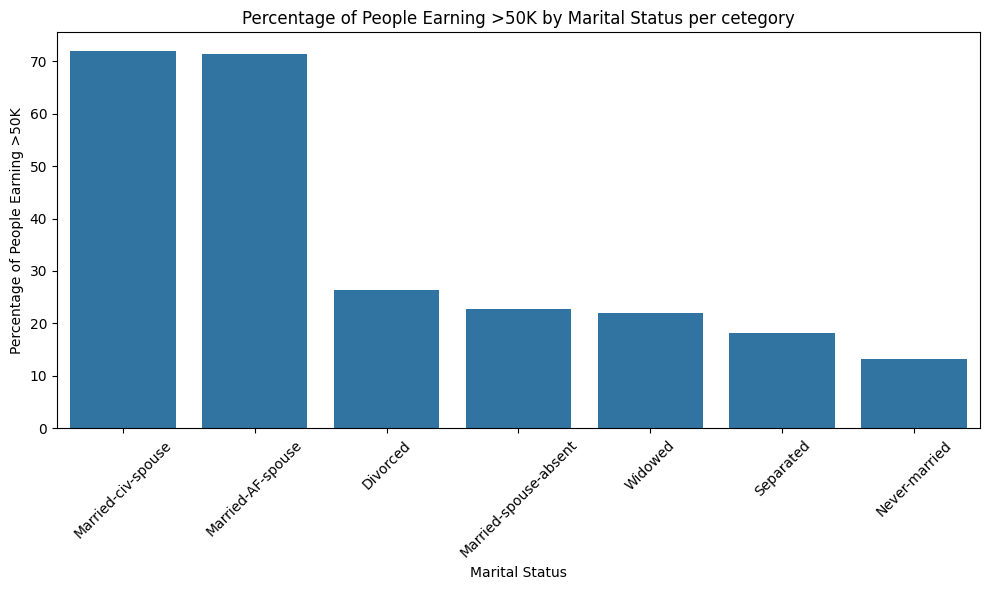

In [352]:
# Calculamos el porcentaje de personas que ganan más de 50K por estado civil
# Primero contamos el número total de personas por estado civil
total_counts = df['marital-status'].value_counts()

# Luego, contamos el número de personas que ganan más de 50K por estado civil
over_50k_counts = df[df['income'] == '>50K']['marital-status'].value_counts()

# Calculamos el porcentaje de personas que ganan más de 50K por estado civil
percentage_over_50k = (over_50k_counts / total_counts * 100).sort_values(ascending=False)

# Creamos el gráfico de barras con los porcentajes
plt.figure(figsize=(10, 6))
sns.barplot(x=percentage_over_50k.index, y=percentage_over_50k.values)

# Rotamos las etiquetas del eje x para una mejor legibilidad
plt.xticks(rotation=45)

# Establecemos el título y las etiquetas
plt.title('Percentage of People Earning >50K by Marital Status per cetegory')
plt.xlabel('Marital Status')
plt.ylabel('Percentage of People Earning >50K')

# Mostramos el gráfico
plt.tight_layout()
plt.show()


This graphic show the total data per category, what percent have more than 50k income per year
It's impresive the married people have more income tha the other marital status

Let´s to look the matrix of confusión